In [1]:
import numpy as np
import gymnasium as gym
import tensorflow as tf
import tqdm.notebook as tqdm
import gymnasium.utils.save_video
import matplotlib.pyplot as plt

2024-04-30 17:30:00.012645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 17:30:01.322798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-04-30 17:30:03.245020: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 17:30:03.543146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 17:30:03.543802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
env = gym.make('ALE/DemonAttack-v5', render_mode='rgb_array')
eval_env = gym.make('ALE/DemonAttack-v5')

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


/home/mimisha/.pyenv/versions/atari-venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


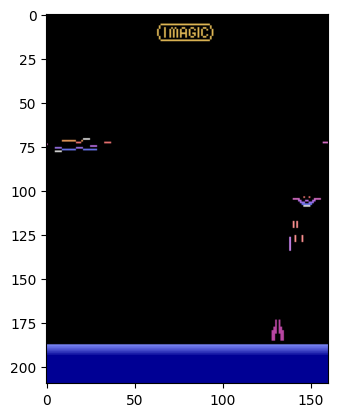

In [4]:
env.reset()
plt.imshow(env.render())

In [5]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '/') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

In [6]:
def get_model(
    input_features: int, 
    features: int,
    out_features: int,
    blocks: int, 
    activation: str | tf.keras.layers.Activation | None = 'silu',
    dropout: float = 0.,
    multiply_freq: int = 1,
    name: str | None = None
) -> tf.keras.Model:
    inputs = x = tf.keras.layers.Input((input_features, ), name=get_name(name, 'input'))

    for i in range(blocks):
        # position, velocity, angle, angle velocity
        x = tf.keras.layers.Dense(features, activation=activation, name=get_name(name, f'dense_{i}'))(x)
        if dropout > 0:
            x = tf.keras.layers.Dropout(dropout, name=get_name(name, f'dropout_{i}'))(x)

        if multiply_freq > 0 and (i + 1) % multiply_freq == 0:
            features *= 2

    x = tf.keras.layers.Dense(out_features, name=get_name(name, 'prediction'))(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name=name)

In [7]:
class Buffer:

    def __init__(self, max_size: int, seed: int=0):
        self.max_size = max_size
        self.current_state = np.zeros((max_size, 8))
        self.action = np.zeros(max_size, dtype=int)
        self.reward = np.zeros(max_size)
        self.next_state = np.zeros((max_size, 8))
        self.done = np.zeros(max_size)
        self.step = 0
        self.rng = np.random.default_rng(seed=seed)
        self.len = 0
        
    def add(self, 
            current_state: np.ndarray, 
            action: np.ndarray, 
            reward: np.ndarray, 
            next_state: np.ndarray, 
            done: np.ndarray
           ):
        self.current_state[self.step] = current_state
        self.action[self.step] = action
        self.reward[self.step] = reward
        self.next_state[self.step] = next_state
        self.done[self.step] = done
        self.step = (self.step + 1) % self.max_size
        self.len = min(self.len + 1, self.max_size)
        
    def sample(self, n: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        indicies = self.rng.choice(self.len, size=n)
        return (
            self.current_state[indicies], 
            self.action[indicies], 
            self.reward[indicies], 
            self.next_state[indicies], 
            self.done[indicies]
        )

    def clear(self):
        self.step = self.len = 0

    def __getitem__(self, i: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        return (
            self.current_state[i], 
            self.action[i], 
            self.reward[i], 
            self.next_state[i], 
            self.done[i]
        )
        
    def __len__(self) -> int:
        return self.len

In [8]:
def play_game(model: tf.keras.Model, buffer: Buffer | None, env: gym.Env, max_steps: int, sample, one_episode: bool = False, s: np.ndarray | None = None):
    if s is None:
        s, _ = env.reset()

    buffer = buffer if buffer is not None else Buffer(1) # cannot do or

    for i in range(max_steps):
        a = sample(model(s[None], training=False).numpy()[0])
        new_s, score, done, terminated, _ = env.step(a)
        
        buffer.add(s, a, score, new_s, done)

        if done or terminated:
            if one_episode:
                return
                
            s, _ = env.reset()
            continue
            
        s = new_s

    return s

In [9]:
class Sampler:
    def __init__(self, epsilon: float, seed: int = 0):
        self.rng = np.random.default_rng(seed=seed)
        self.epsilon = epsilon
        
    def __call__(self, a: np.ndarray):
        if self.rng.random() < self.epsilon:
            return self.rng.integers(a.shape[0])
        return np.argmax(a)

In [10]:
def Q_loss(
    current_state: np.ndarray | tf.Tensor, 
    action: np.ndarray | tf.Tensor, 
    reward: np.ndarray | tf.Tensor, 
    next_state: np.ndarray | tf.Tensor, 
    done: np.ndarray | tf.Tensor,
    model: tf.keras.Model,
    target_model: tf.keras.Model,
    gamma: float
):
    q_current = model(current_state)
    q_next = target_model(next_state)
    q_ref = reward + gamma * tf.math.reduce_max(q_next, axis=-1) * (1. - done)
    q = tf.reshape(tf.gather(q_current, tf.expand_dims(action, axis=-1), batch_dims=1), (-1, ))
    return tf.math.reduce_mean(tf.square(q_ref - q))

In [11]:
def QQ_loss(
    current_state: np.ndarray | tf.Tensor, 
    action: np.ndarray | tf.Tensor, 
    reward: np.ndarray | tf.Tensor, 
    next_state: np.ndarray | tf.Tensor, 
    done: np.ndarray | tf.Tensor,
    model: tf.keras.Model,
    target_model: tf.keras.Model,
    gamma: float
):
    q_current = model(current_state)
    q_next = target_model(next_state)

    a_next = tf.argmax(model(next_state), axis=-1)
    
    # q_ref = tf.stop_gradient(reward + gamma * tf.reshape(tf.gather(q_next, tf.expand_dims(a_next, axis=-1), batch_dims=1), (-1, )) * (1. - done))
    q_ref = reward + gamma * tf.reshape(tf.gather(q_next, tf.expand_dims(a_next, axis=-1), batch_dims=1), (-1, )) * (1. - done)
    
    q = tf.reshape(tf.gather(q_current, tf.expand_dims(action, axis=-1), batch_dims=1), (-1, ))

    return tf.math.reduce_mean(tf.square(q_ref - q))

In [ ]:
model = get_model(8, 16, 4, 12, name='lanar_lander', dropout=0.1, multiply_freq=2, activation='swish')

In [ ]:
target_model = get_model(8, 16, 4, 12, name='target_lander', multiply_freq=2, activation='swish')

In [ ]:
target_model.trainable = False
target_model.set_weights(model.get_weights())

In [ ]:
train_buffer = Buffer(100000)
train_sampler = Sampler(1)

In [ ]:
eval_buffer = Buffer(1000)
eval_sampler = Sampler(0)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4, clipnorm=5, weight_decay=2e-5)

In [ ]:
epochs = 10 ** 5
batch_size = 1024
decay_epochs = epochs // 2
end_epsilon = 0.1
update_frequency = 512
eval_frequency = 512
steps_per_epoch = 32
eval_steps = 1000
initial_samples = 10000
n_evals = 5
eval_threshold = 200

In [ ]:
play_game(model, train_buffer, env, initial_samples, train_sampler)

In [ ]:
epsilon_decay = tf.keras.optimizers.schedules.PolynomialDecay(1., decay_epochs, end_learning_rate=end_epsilon)

In [ ]:
losses = []
total_loss = 0
eval_score = 0

s, _ = env.reset()
pbar = tqdm.trange(epochs)
for i in pbar:
    train_sampler.epsilon = epsilon_decay(i).numpy()
    
    s = play_game(model, train_buffer, env, steps_per_epoch, train_sampler, s=s)
    
    vals = train_buffer.sample(batch_size)
    with tf.GradientTape(watch_accessed_variables=False) as g:
        g.watch(model.trainable_weights)
        loss = QQ_loss(*vals, model, target_model, 0.99)

    gradient = g.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradient, model.trainable_weights))
    
    losses.append(loss.numpy())
    total_loss += losses[-1]

    if (i + 1) % update_frequency == 0:
        target_model.set_weights(model.get_weights())

    if (i + 1) % eval_frequency == 0:
        eval_score = 0

        for i in range(n_evals):
            eval_buffer.clear()
            play_game(model, eval_buffer, eval_env, eval_steps, eval_sampler, one_episode=True)
            eval_score += eval_buffer.reward[:len(eval_buffer)].sum()

        eval_score /= n_evals
        if eval_score >= eval_threshold:
            break

    pbar.set_description(f'L: {losses[-1]:.5f}; AL: {total_loss / (i + 1):.5f}; E: {eval_score:.5f}')

In [ ]:
target_model.set_weights(model.get_weights())

In [ ]:
def save_gameplay(model: tf.keras.Model, render_mode: str = 'human'):
    env = gym.make('LunarLander-v2', render_mode=render_mode)
    buffer = Buffer(1000)
    play_game(model, buffer, env, 1000, Sampler(0), one_episode=True)
    render = env.render()
    # gym.utils.save_video.save_video(render, 'videos', durations=[1] * len(render))
    return render, buffer

In [ ]:
a, b = save_gameplay(model)

In [ ]:
b.reward.sum()